# New metrics for identifying variables and transients in large astronomical surveys

Shih Ching Fu (<shihching.fu@postgrad.curtin.edu.au>)

November 2024

This notebook accompanies "New metrics for identifying variables and transients in large astronomical surveys" (Fu et al. 2024).


In [2]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import pymc as pm
import arviz as az
from pymc.gp.util import plot_gp_dist

print(f"Running on PyMC v{pm.__version__}")
az.style.use("arviz-white")

Running on PyMC v5.16.1


In [3]:
RANDOM_SEED = 0
rng = np.random.default_rng(RANDOM_SEED)

N_CHAINS = 4
LENGTH_BURNIN = 2000
LENGTH_CHAIN = 1000
LENGTH_TSTAR = 200
N_PPC_SAMPLES = 200
N_PSD_SAMPLES = 400

## Data

In [5]:
lc_df = pd.read_csv("data/195_ra281.904_dec-2.033_J1848GTraPDB_andersson.csv")
lc_df = lc_df.sort_values(by="time_MJD", ascending=True)
lc_df.head()

,time_MJD,flux_density_Jy,flux_density_se_Jy
0,59286.109817,0.061282,0.003840
1,59293.150351,0.049311,0.001467
2,59301.290444,0.045059,0.001698
3,59309.184837,0.046642,0.001564
4,59314.093273,0.050941,0.002062


In [6]:
mean_flux_density = np.nanmean(lc_df['flux_density_Jy'])
sd_flux_density = np.nanstd(lc_df['flux_density_Jy'])
start_MJD = np.nanmin(lc_df['time_MJD'])

# Standardise flux densities and uncertainties
t = lc_df['time_MJD'].to_numpy() - start_MJD
y = (lc_df['flux_density_Jy'].to_numpy() - mean_flux_density)/sd_flux_density
y_se = lc_df['flux_density_se_Jy'].to_numpy()/sd_flux_density

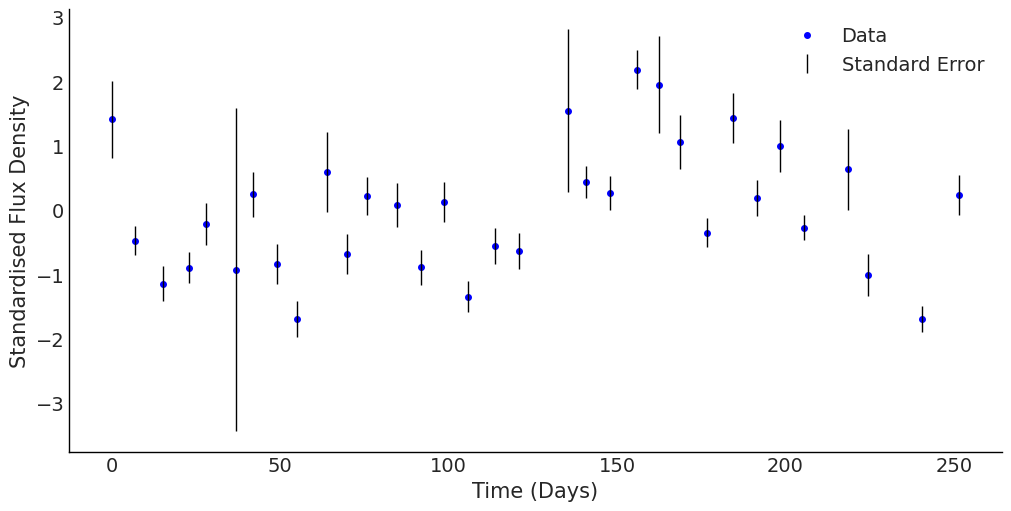

In [7]:
fig = plt.figure(figsize=(10,5))
plt.plot(t, y, ".b", ms=8, alpha=1, label="Data");
plt.errorbar(x=t, y=y, yerr=y_se,
                fmt="none", ecolor="black", elinewidth=1,
                label="Standard Error")
plt.xlabel("Time (Days)")
plt.ylabel("Standardised Flux Density")
plt.legend();

## Model

$$Y_i \sim \mathcal{N}(f(t_i), \sigma_i^2) \qquad i = 1, \dots, N.$$

$$f \sim \mathcal{GP}(\boldsymbol{0}, \kappa(t,  t'))$$

$$\sigma_i = \hat{e}_i$$

$$\kappa(t,t') = \sigma^2_\textrm{SE} \exp\left\{ -\frac{1}{2}\frac{(t - t')^2}{\ell_\mathrm{SE}^2}\right\} +  \sigma^2_\textrm{M32} \left( 1 + \frac{\sqrt{3}|t - t'|}{\ell_\textrm{M32}}\right)\exp\left\{ - \frac{\sqrt{3}|t - t'|}{\ell_\textrm{M32}}\right\} + \sigma^2_\textrm{P}\exp\left\{ -\frac{2 \sin^2\left( \pi\frac{|t - t'|}{T}\right)}{\ell_\mathrm{P}^2}\right\}$$

$$\sigma_\textrm{SE}, \sigma_\textrm{M32}, \sigma_\textrm{P} \sim \mathcal{N}^+(0,1)$$

$$\ell_\textrm{SE}, \ell_\textrm{M32}, \ell_\textrm{P} \sim \mathrm{InvGamma}\left(3, \frac{1}{2} \times \lceil\textrm{range}(t)\rceil\right)$$

$$T \sim \mathcal{U}\left[2 \times \textrm{min}(\Delta t), \ell_\textrm{P}\right]$$

$$\ell_\textrm{M32} > \textrm{min}(\Delta t), \quad \ell_\textrm{P} > \textrm{min}(\Delta t)$$

$$\ell_\textrm{SE} > \ell_\textrm{M32}$$

In [8]:
N_t = t.shape[0]
min_t = np.nanmin(t)
max_t = np.nanmax(t)
mingap_t = np.diff(np.sort(t)).min()
range_t = np.ptp(t)

t_star = np.linspace(start= min_t, stop=max_t, num = LENGTH_TSTAR)

## pymc Implementation

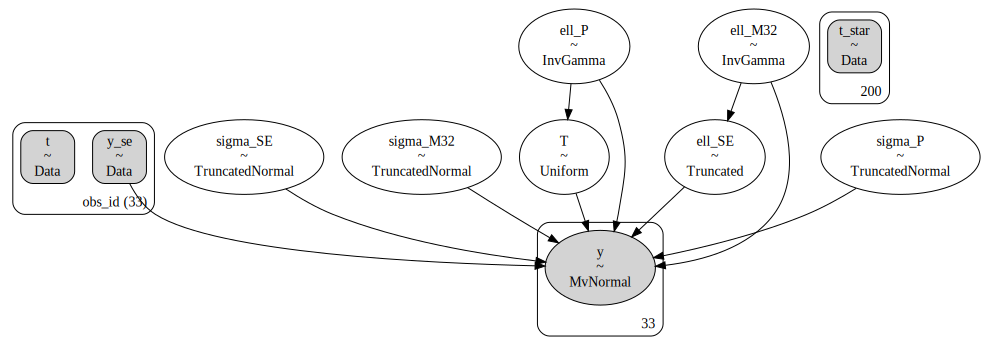

In [10]:
coords = {"t": t, "t_star": t_star}

with pm.Model(coords=coords) as marginal_gp_model:
    t_ = pm.Data("t", t, dims="obs_id")
    t_star_ = pm.Data("t_star", t_star)
    y_se_ = pm.Data("y_se", y_se, dims="obs_id")

    # Hyperpriors    
    sigma_SE  = pm.TruncatedNormal("sigma_SE", mu=0, sigma=1, lower=0)
    sigma_M32 = pm.TruncatedNormal("sigma_M32", mu=0, sigma=1, lower=0)
    sigma_P   = pm.TruncatedNormal("sigma_P", mu=0, sigma=1, lower=0)

    inv_gamma = pm.InverseGamma.dist(alpha=3, beta=0.5*range_t)

    ell_M32 = pm.InverseGamma("ell_M32", alpha=3, beta=0.5*range_t)
    ell_SE  = pm.Truncated("ell_SE", inv_gamma, lower = ell_M32)
    ell_P   = pm.InverseGamma("ell_P", alpha=3, beta=0.5*range_t)

    T = pm.Uniform("T", lower=mingap_t*2, upper=ell_P)
    
    ehat = pm.gp.cov.WhiteNoise(sigma=y_se_)
    
    K_SE  = sigma_SE**2 * pm.gp.cov.ExpQuad(input_dim=1, ls=ell_SE)
    K_M32 = sigma_M32**2 * pm.gp.cov.Matern32(input_dim=1, ls=ell_M32)
    K_P   = sigma_P**2 * pm.gp.cov.Periodic(input_dim=1, period=T, ls=ell_P)

    gp_SE = pm.gp.Marginal(cov_func=K_SE)
    gp_M32 = pm.gp.Marginal(cov_func=K_M32)
    gp_P = pm.gp.Marginal(cov_func=K_P)

    gp = gp_SE + gp_M32 + gp_P 
   
    y_ = gp.marginal_likelihood("y", X=t.reshape(-1,1), y=y.reshape(-1,1).flatten(), sigma=ehat)

pm.model_to_graphviz(marginal_gp_model)

## Prior Predictive Checks

Sampling: [T, ell_M32, ell_P, ell_SE, sigma_M32, sigma_P, sigma_SE, y]


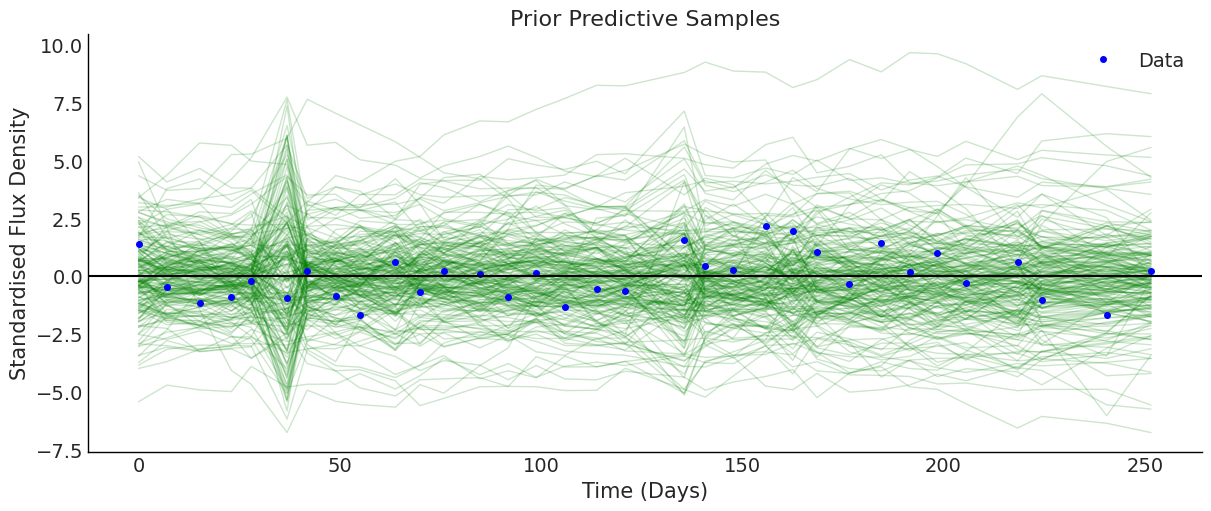

In [12]:
with marginal_gp_model:
    idata = pm.sample_prior_predictive(samples=N_PPC_SAMPLES,
                                       idata_kwargs={"dims": {"y": ["t"]}})
    
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,1,1)

for prior_pred in idata.prior_predictive.y.to_numpy()[0]:
    ax.plot(t, prior_pred, lw=1, alpha=0.2, color="green")

plt.plot(t, y, ".b", ms=8, alpha=1, label="Data")
ax.axhline(0, color="black")
ax.set_title("Prior Predictive Samples")
plt.xlabel("Time (Days)")
plt.ylabel("Standardised Flux Density")
plt.legend();

## MCMC Fitting

In [13]:
with marginal_gp_model:
    idata.extend(
        pm.sample(
            draws=LENGTH_CHAIN, 
            tune=LENGTH_BURNIN, 
            chains=N_CHAINS,
            cores=N_CHAINS
        )
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_SE, sigma_M32, sigma_P, ell_M32, ell_SE, ell_P, T]


Output()

/home/scf/.venv/lib/python3.12/site-packages/pymc/step_methods/hmc/integration.py:124: RuntimeWarning: invalid value encountered in subtract
  energy = kinetic - logp


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 72 seconds.
There were 52 divergences after tuning. Increase `target_accept` or reparameterize.


## Results

In [14]:
variable_names = ["sigma_SE", "sigma_M32", "sigma_P", "ell_SE", "ell_M32", "ell_P", "T"]
posterior_summary = az.summary(idata, stat_focus="median", fmt="wide", var_names=variable_names, round_to=5, kind="all")
posterior_summary

,median,mad,eti_3%,eti_97%,mcse_median,ess_median,ess_tail,r_hat
sigma_SE,0.35871,0.22259,0.01855,1.36122,0.00867,3232.33362,1512.62768,1.00117
sigma_M32,1.20911,0.17296,0.81531,1.88126,0.00537,3267.55537,2692.25886,1.00156
sigma_P,0.45613,0.29050,0.02520,1.79895,0.00873,3127.87530,1794.73646,1.00047
ell_SE,48.75932,18.38978,19.25034,212.63973,0.51401,5337.05459,2460.15278,1.00128
ell_M32,12.50168,2.02934,8.12428,20.12715,0.07633,3147.73093,2420.32207,1.00069
ell_P,47.09455,18.30916,17.89178,189.50875,0.44576,4093.70069,2429.16640,1.00072
T,25.46406,10.64029,10.73673,110.36952,0.31354,4275.74466,2724.15336,1.00034


### Hyperparameter Posteriors

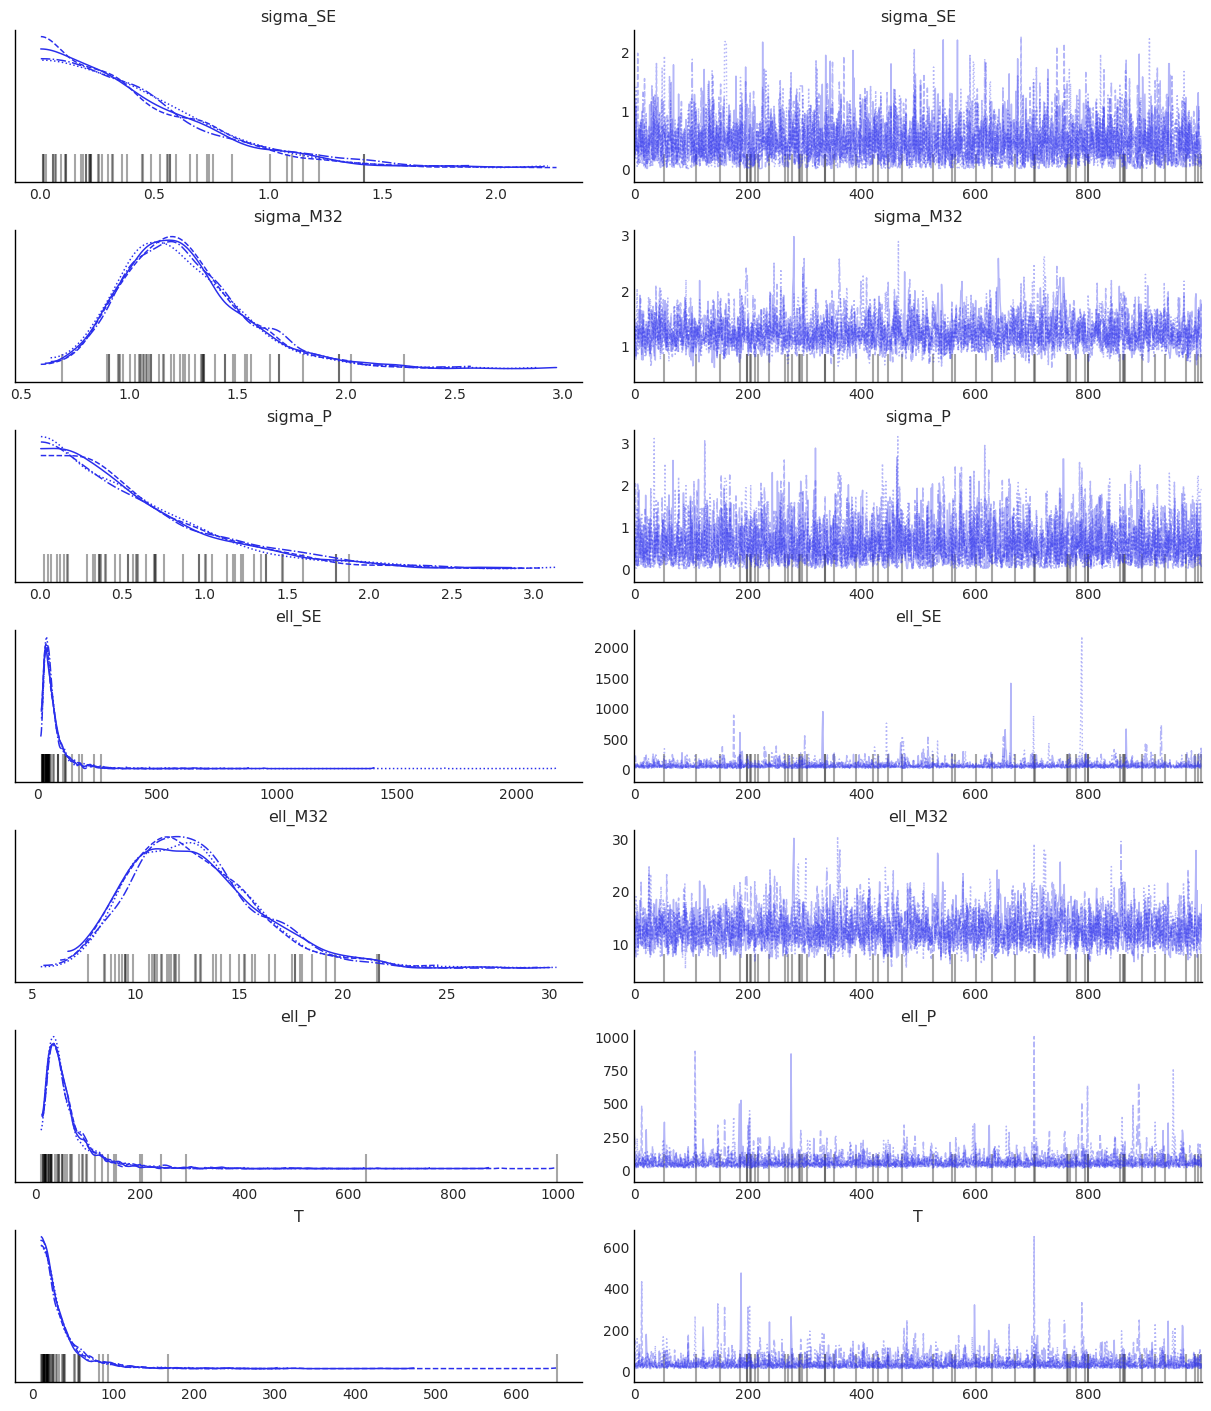

In [15]:
az.plot_trace(idata, var_names=variable_names, combined=False);

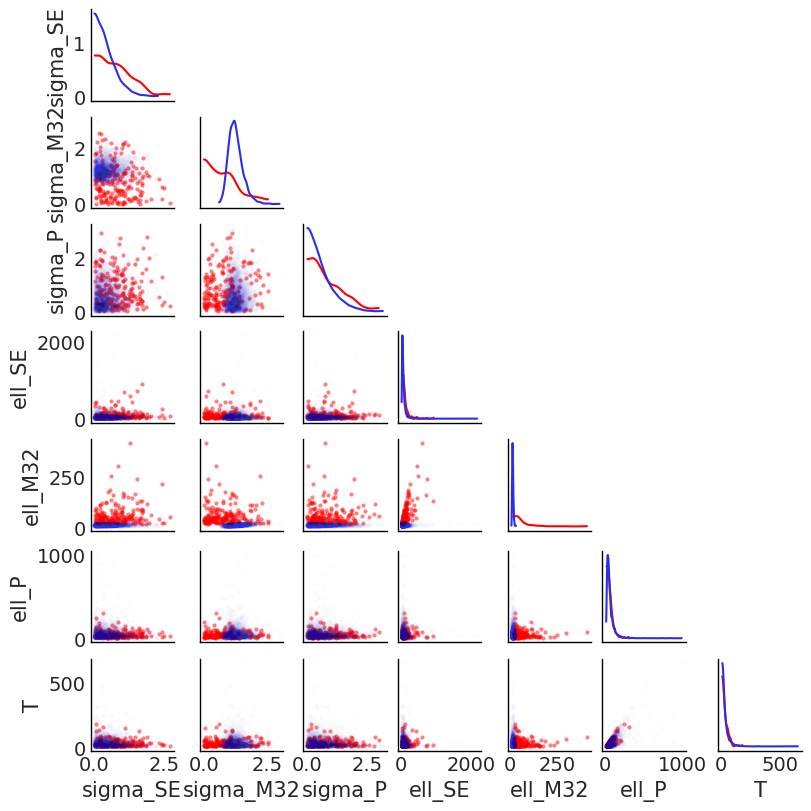

In [16]:
ax_list = az.plot_pair(
    idata, 
    group="prior", 
    var_names=variable_names,
    marginals=True, 
    figsize=(8,8), 
    kind=["scatter"],
    marginal_kwargs={"color":"red"},
    scatter_kwargs={"alpha":0.5, "color":"red"}
)

az.plot_pair(
    idata, 
    group="posterior",
    var_names=variable_names,
    marginals=True, 
    kind=["scatter"], 
    ax=ax_list, 
    scatter_kwargs={"alpha":0.01}
);

## Posterior Predictive Samples

In [17]:
with marginal_gp_model:
    # Samples drawn from each kernel component
    f_star_SE = gp_SE.conditional("f_star_SE", Xnew=t_star.reshape(-1,1),
                                    given={"X": t.reshape(-1,1), "y": y.reshape(-1,1).flatten(), "sigma": ehat, "gp": gp})

    f_star_M32 = gp_M32.conditional("f_star_M32", Xnew=t_star.reshape(-1,1),
                                    given={"X": t.reshape(-1,1), "y": y.reshape(-1,1).flatten(), "sigma": ehat, "gp": gp})

    f_star_P = gp_P.conditional("f_star_P", Xnew=t_star.reshape(-1,1),
                                    given={"X": t.reshape(-1,1), "y": y.reshape(-1,1).flatten(), "sigma": ehat, "gp": gp})

    f_star = gp.conditional(name="f_star",
                            Xnew=t_star.reshape(-1,1),
                            jitter=1e-6,
                            pred_noise=False)

In [18]:
thinned_idata = idata.sel(draw=slice(None, None, 5))

with marginal_gp_model:
    idata.extend(
        pm.sample_posterior_predictive(
            thinned_idata,
            var_names=["f_star", "f_star_SE", "f_star_M32", "f_star_P"],
            idata_kwargs={"dims": {"f_star": ["t_star"]}}
        )
    )

Sampling: [f_star, f_star_M32, f_star_P, f_star_SE]


Output()

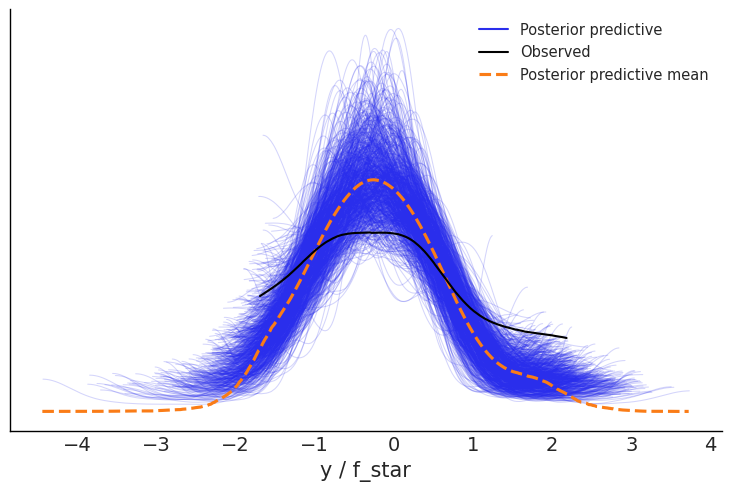

In [19]:
az.plot_ppc(idata, data_pairs={"y":"f_star"});

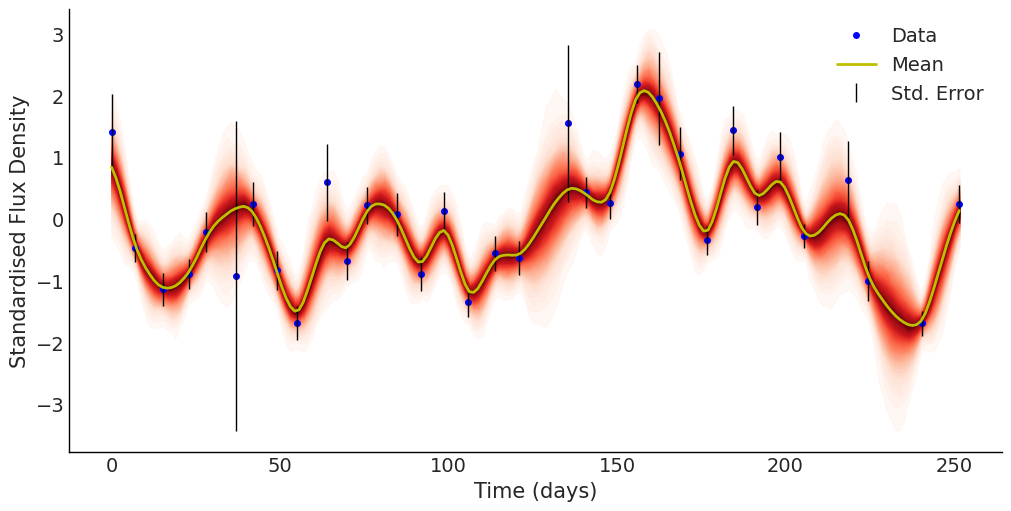

In [20]:
fstar_samples = az.extract(idata, "posterior_predictive", var_names=["f_star"])
fstar_mean = fstar_samples.mean(dim="sample")

fig = plt.figure(figsize=(10, 5))
ax = fig.gca()
plt.plot(t, y, ".b", ms=8, alpha=1, label="Data")
plt.errorbar(x=t, y=y, yerr=y_se, fmt="none", ecolor="k", elinewidth=1, label="Std. Error")
plot_gp_dist(
    ax=ax, 
    samples=fstar_samples.transpose("sample", ...),
    x=t_star,
    plot_samples=False
)
plt.plot(t_star.flatten(), fstar_mean, "y", linewidth=2, label="Mean")
plt.xlabel("Time (days)")
plt.ylabel("Standardised Flux Density")
plt.legend();

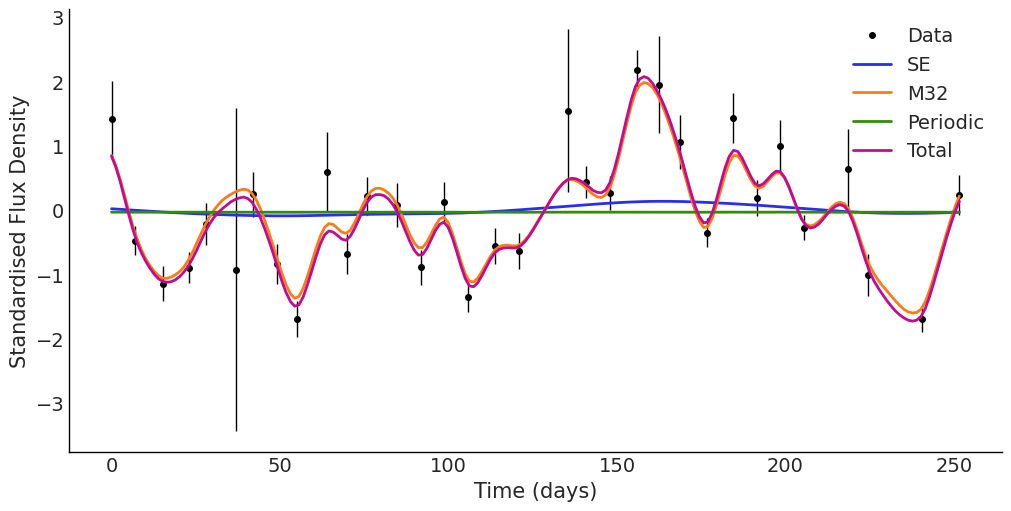

In [21]:
fstarSE = az.extract(idata, "posterior_predictive", var_names=["f_star_SE"])
fstarSE_mean = fstarSE.mean(dim="sample")
fstarM32 = az.extract(idata, "posterior_predictive", var_names=["f_star_M32"])
fstarM32_mean = fstarM32.mean(dim="sample")
fstarP = az.extract(idata, "posterior_predictive", var_names=["f_star_P"])
fstarP_mean = fstarP.mean(dim="sample")

fig = plt.figure(figsize=(10, 5))
ax = fig.gca()
plt.plot(t, y, ".k", ms=8, alpha=1, label="Data")
plt.errorbar(x=t, y=y, yerr=y_se, fmt="none", ecolor="k", elinewidth=1)
plt.plot(t_star.flatten(), fstarSE_mean, linewidth=2, label="SE")
plt.plot(t_star.flatten(), fstarM32_mean, linewidth=2, label="M32")
plt.plot(t_star.flatten(), fstarP_mean, linewidth=2, label="Periodic")
plt.plot(t_star.flatten(), fstar_mean, linewidth=2, label="Total")
plt.xlabel("Time (days)")
plt.ylabel("Standardised Flux Density")
plt.legend();

## Location in $(\sigma_\textrm{M32}, \sigma_\textrm{SE})$-space

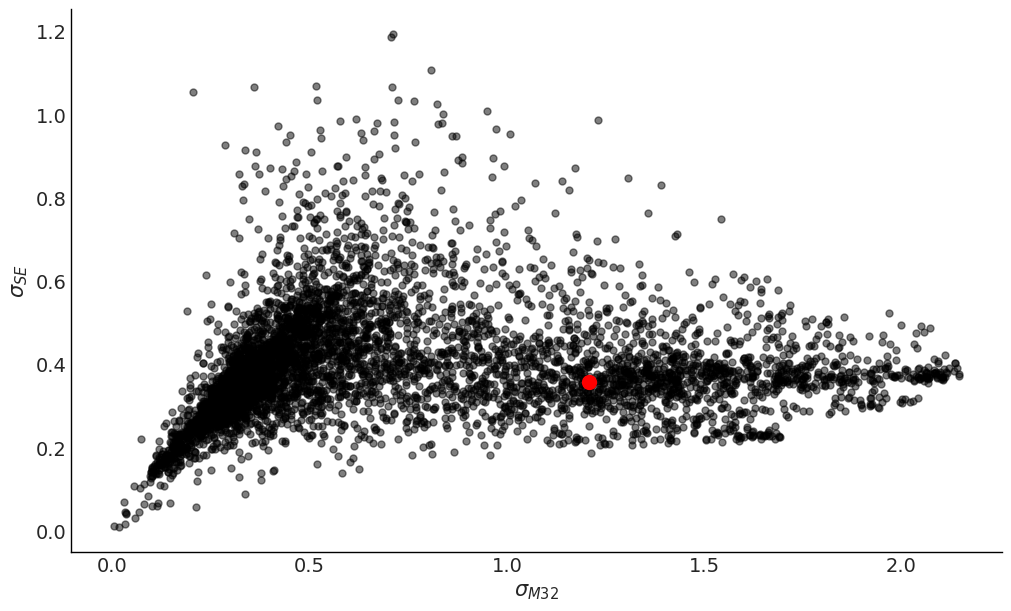

In [24]:
sigma_medians_df = pd.read_csv("data/sigma_medians.csv")

fig = plt.figure(figsize=(10, 6))
ax = fig.gca()
plt.plot(sigma_medians_df['sigma_M32'], sigma_medians_df['sigma_SE'], ".k", ms=10, alpha=0.5)
plt.plot(posterior_summary['median']['sigma_M32'], posterior_summary['median']['sigma_SE'], '.r', ms=20)
plt.xlabel(r"$\sigma_{M32}$")
plt.ylabel(r"$\sigma_{SE}$");